''Stokes Sinker''
======

Demonstration example for setting up particle swarms with different material properties. This system consists of a dense, high viscosity sphere falling through a background lower density and viscosity fluid. 

**This lesson introduces the concepts of:**
1. Creating particle swarms.
2. Associating different behaviours with different particles.
3. Using the ``branching.conditional`` function.
4. Advecting particle swarms in a Stokes system.
5. Calibrating the stokes pressure solution using a solver callback routine. `callback_post_solve`

**Keywords:** particle swarms, Stokes system, advective diffusive systems, pressure calibration 


![title](./images/1_05_matvel.png)

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
import math
from mpi4py import MPI

Setup parameters
-----

Set simulation parameters for the test and position of the spherical sinker.

In [2]:
# Set the resolution.
res = 64

# Set size and position of dense sphere.
sphereRadius = 0.1
sphereCentre = (0., 0.7)

Create mesh and finite element variables
------

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (-1., 0.), 
                                 maxCoord    = (1., 1.))

velocityField    = mesh.add_variable(         nodeDofCount=2 )
pressureField    = mesh.subMesh.add_variable( nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial and boundary conditions**

Initialise the velocity and pressure fields to zero.

In [4]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls to define conditons for underworld solvers.

In [5]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )

Create a particle swarm
------

Swarms refer to (large) groups of particles which can advect with the fluid flow. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

**Setup a swarm**

To set up a swarm of particles the following steps are needed:
1. Initialise and name a swarm, here called ``swarm``.
2. Define data variable (``materialIndex``) to store an index that will state what material a given particle is.
3. Populate the swarm over the whole domain using the layout command, here this is used to allocate 20 particles in each element.

In [6]:
# Create the swarm and an advector associated with it
swarm = uw.swarm.Swarm( mesh=mesh )
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

# Add a data variable which will store an index to determine material.
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# Go ahead and populate the swarm.
swarm.populate_using_layout( layout=swarmLayout )

**Define a shape**
 1. Define an underworld `function` that descripes the geometry of a shape (a sphere), called `fn_sphere`.
 2. Set up a `fn.branching.conditional` to run `fn_sphere` and return a given index - either `materialLightIndex` or `materialHeavyIndex`.
 3. Execute the above underworld functions on the swarm we created and save the result on the `materialIndex` swarm variable.
 

In [7]:
# create a function for a sphere. returns `True` if query is inside sphere, `False` otherwise.
coord = fn.input() - sphereCentre
fn_sphere = fn.math.dot( coord, coord ) < sphereRadius**2

# define some names for our index 
materialLightIndex = 0
materialHeavyIndex = 1

# set up the condition for being in a sphere. If not in sphere then will return light index.
conditions = [ ( fn_sphere , materialHeavyIndex), 
               ( True      , materialLightIndex) ]

# Execute the branching conditional function, evaluating at the location of each particle in the swarm.
# The results are copied into the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Branching conditional function**

For more information on the `fn.branching.conditional` see the Functions user guide [here](../user_guide/05_Functions.ipynb)

**Define minimum y coordinate function**

 1. Define a new swarm called `tracerSwarm`, with one particle at the base of the sphere. (This swarm behaves as a passive tracer swarm).
 2. Define a function that finds the minimum y coordinate value of the `tracerSwarm` in a parallel safe way.

In [8]:
# build a tracer swarm with one particle
tracerSwarm = uw.swarm.Swarm(mesh)
advector_tracer = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )

# build a numpy array with one particle, specifying it's exact location
x_pos = sphereCentre[0]
y_pos = sphereCentre[1]-sphereRadius
coord_array = np.array(object=(x_pos,y_pos),ndmin=2)
tracerSwarm.add_particles_with_coordinates(coord_array)

# define a y coordinate `min_max` function
fn_ycoord = fn.view.min_max( fn.coord()[1] )

def GetSwarmYMin():
    fn_ycoord.reset()
    fn_ycoord.evaluate(tracerSwarm)
    return fn_ycoord.min_global()

**Test minimum y coordinate function**

In [9]:
ymin = GetSwarmYMin()
if(uw.rank()==0):
    print('Minimum y value for sinker = {0:.3e}'.format(ymin))

Minimum y value for sinker = 6.000e-01


**Plot the particles by material**

Plot the initial positions of all swarm particles coloured by their material indices.


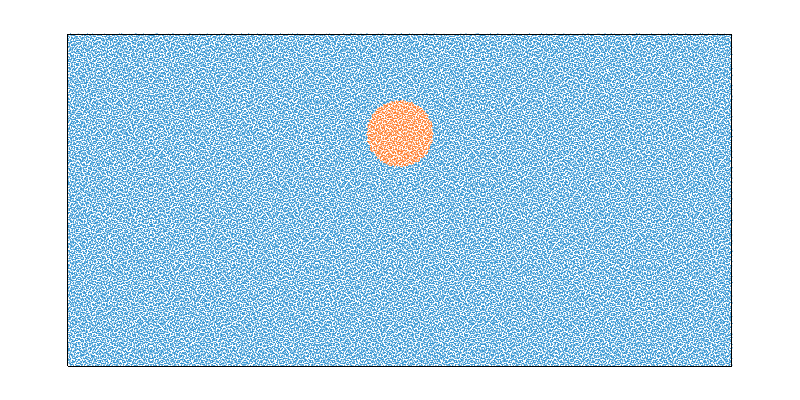

In [10]:
fig1 = glucifer.Figure( figsize=(800,400) )
fig1.Points(swarm, materialIndex, colourBar=False, pointSize=2.0)
fig1.VectorArrows(mesh, velocityField)
fig1.show()

Set up material parameters and functions
-----

Here the functions for density and viscosity are set using the ``map`` function. This function evaluates a key function (here the material index), and the result (i.e. the key) is used to determine which function to evaluate to obtain the actual result (such as the particle density). 

For example if the material index of a particle is the light index number then the viscosity for that particle will be set to 1. If it had the heavy index number then it will be set to ``visc_sphere``, which can be either a function (say depending on temperature) or a constant as it is below.

The same approach is taken when setting up the density function for each particle in the swarm.

In [11]:
# Set constants for the viscosity and density of the sinker.
viscSphere = 10.0
densitySphere = 10.0

# Here we set a viscosity value of '1.' for both materials 
mappingDictViscosity = { materialLightIndex:1., materialHeavyIndex:viscSphere }
# Create the viscosity map function.
viscosityMapFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictViscosity )
# Here we set a density of '0.' for the lightMaterial, and '1.' for the heavymaterial.
mappingDictDensity = { materialLightIndex:1., materialHeavyIndex:densitySphere }
# Create the density map function.
densityFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictDensity )

# And the final buoyancy force function.
z_hat = ( 0.0, 1.0 )
buoyancyFn = -densityFn * z_hat

System setup
-----

**Setup a Stokes system**

In [12]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = freeslipBC,
                               fn_viscosity  = viscosityMapFn, 
                               fn_bodyforce  = buoyancyFn )
solver = uw.systems.Solver( stokes )

In [13]:
top = mesh.specialSets["MaxJ_VertexSet"]
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    print "Zeroing pressure using mean upper surface pressure {}".format( offset )
    pressureField.data[:] -= offset

Analysis tools
-----

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [14]:
vdotv = fn.math.dot( velocityField, velocityField )

Main simulation loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

Note that there are two ``advector.integrate`` steps, one for each swarm, that need to be done each time step.

In [15]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    advector_tracer.integrate(dt)
    return time+dt, step+1

In [16]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
nsteps = 3
if(uw.rank()==0):
    tSinker = np.zeros(nsteps)
    ySinker = np.zeros(nsteps)
# Perform 10 steps
while step<nsteps:
    # Get velocity solution - using callback
    solver.solve( callback_post_solve = pressure_calibrate )
    ymin = GetSwarmYMin()
    # Calculate the RMS velocity
    vrms = math.sqrt( mesh.integrate(vdotv)[0] / mesh.integrate(1.)[0] )
    if(uw.rank()==0):
        ySinker[step] = ymin
        tSinker[step] = time
        print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}; height = {3:.3e}'
              .format(step,time,vrms,ymin))
    
    # update
    time, step = update()

Zeroing pressure using mean upper surface pressure -0.596408054426
step =      0; time = 0.000e+00; v_rms = 9.017e-03; height = 6.000e-01
Zeroing pressure using mean upper surface pressure -0.595172629777
step =      1; time = 3.000e-01; v_rms = 9.154e-03; height = 5.925e-01
Zeroing pressure using mean upper surface pressure -0.59377412334
step =      2; time = 5.961e-01; v_rms = 9.298e-03; height = 5.849e-01


Post simulation analysis
-----

**Plot trajectory**

Plot the sinker's trajectory with time.

Initial position: t = 0.000, y = 0.600
Final position:   t = 0.596, y = 0.585


/home/julian/codes/venvs/vanilla/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


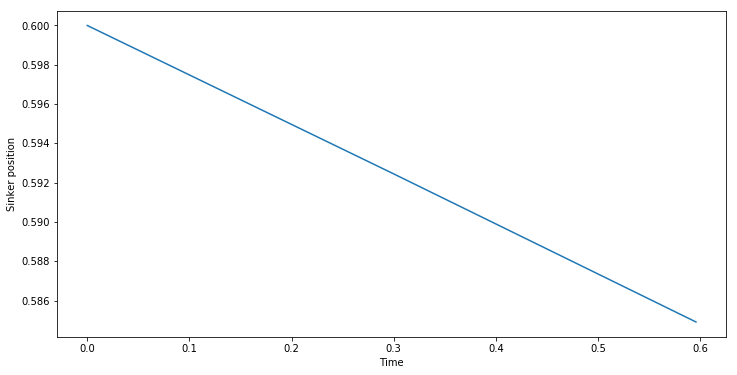

In [17]:
if(uw.rank()==0):
    print('Initial position: t = {0:.3f}, y = {1:.3f}'.format(tSinker[0], ySinker[0]))
    print('Final position:   t = {0:.3f}, y = {1:.3f}'.format(tSinker[nsteps-1], ySinker[nsteps-1]))

    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    fig = pyplot.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    ax.plot(tSinker, ySinker) 
    ax.set_xlabel('Time')
    ax.set_ylabel('Sinker position')
    fig.show()


**Plot the final particle positions**


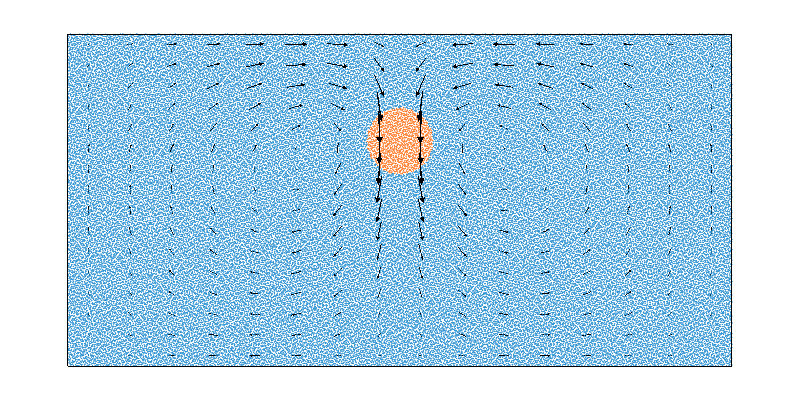

In [18]:
fig1.show()

**Plot velocity and pressure fields**

Plot the velocity field in the fluid induced by the motion of the sinking ball.


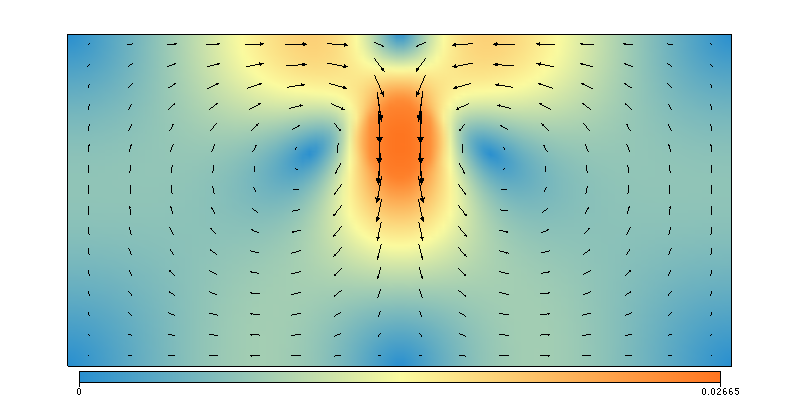


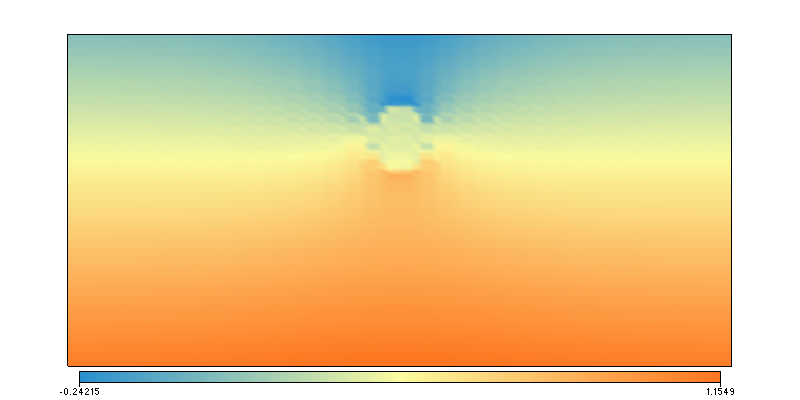

In [19]:
velmagfield = uw.function.math.sqrt( uw.function.math.dot(velocityField,velocityField) )
window_size = (800,400)

fig3 = glucifer.Figure( figsize=window_size )
fig3.VectorArrows(mesh, velocityField)
fig3.Surface(mesh, velmagfield)
fig3.show()

fig4 = glucifer.Figure( figsize=window_size )
fig4.Surface(mesh, pressureField)
fig4.show()